In [1]:
import cv2 as cv
import numpy as np
import json
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
def read_points_3d(name):
    file = open(f"../c++/{name}")
    data = json.load(file)
    res = np.reshape(data["points_3d"], (-1, 3))
    return res

<IPython.core.display.Javascript object>


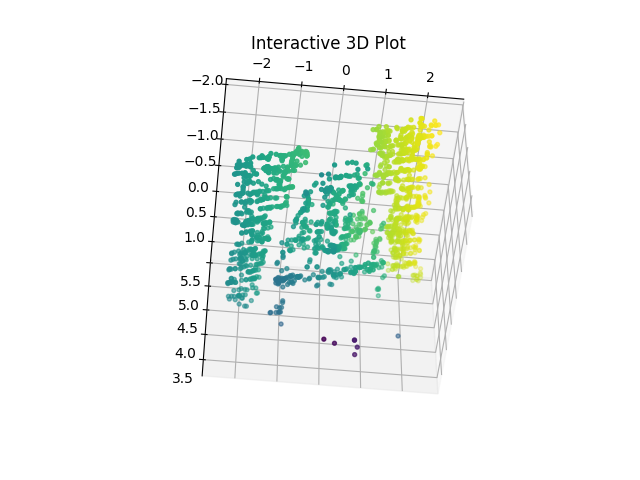

1853


In [12]:
%matplotlib notebook

points = []
# for i in range(10):
#     points.append(read_points_3d(f"points-3d_pairs/{i}-{i+1}.json"))

points.append(read_points_3d(f"points-3d/norm.json"))

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []

for pts in points[:1]:
    for x_pt, y_pt, z_pt in pts:
        if (-150 < x_pt <100) and (-150 < y_pt <100) and (-150 < z_pt <100):
            x.append(x_pt)
            y.append(y_pt)
            z.append(z_pt)

x = np.array(x)
y = np.array(y)
z = np.array(z)

print(len(x))

# Create a 3D scatter plot
ax.scatter(x, y, z, c=z, marker='o', s=8)



# Set the title
ax.set_title('Interactive 3D Plot')

# Show the plot
plt.show()